## Classification Analysis

### Problem Setup

Let's say we've designed a new image classifier for the classic MNIST (10 digit) classification task.

In this question, we're going to explore what happens with our classifier when we train for many epochs & enter the overfitting regime.

*This interview question was largely inspired by https://arxiv.org/abs/1706.04599.*

### Part 1

**Question**: First, let's consider the possible accuracy and cross-entropy loss ($-\sum_{c=1}^{10}y\log(p)$) for a single example for our MNIST classifier (10 digits). Assuming we incorrectly predict this example (ie accuracy=0), what are the lower & upper bounds for the loss? How about for when we correctly predict this example (accuracy=1)?

**Your Answer**:

1) When accuracy = 1: $loss_{lower}= 0 $

2) When accuracy = 1: $loss_{upper}= log10$

3) When accuracy = 0: $loss_{lower}= log2$

4) When accuracy = 0: $loss_{upper}= +inf$

**Question**: What about for multiple examples, ie the entire training set or entire test set? Is there anything we can say about the bounds for when our accuracy is close to 0 or close to 1?

**Your Answer**:

1) When accuracy -> 1: $loss_{lower}= log2 * ϵ$

2) When accuracy -> 1: $loss_{upper}= + inf$

3) When accuracy -> 0: $loss_{lower}= log2$

4) When accuracy -> 0: $loss_{upper}= +inf$

Now try running the below code (no modifications necessary) and consider what happens to the train and test loss and accuracy.

In [1]:
# DO NOT NEED TO MODIFY THIS CELL

import torch
from torch import nn
from torchvision import datasets
from torch.nn import functional as F
import numpy as np
import random
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from collections import defaultdict

class Logger:

    def __init__(self):
        # Track (metric, label): [(x, y)]
        # For ease of plotting later, we'll actually represent this as
        # metric: {label: {x: y}}
        self.results = defaultdict(lambda: defaultdict(dict))

    def log(self, metric, label, x, y):
        # if we had multiple measurements at a particular x-idx,
        # when we plot later we'll take the mean over them
        if x not in self.results[metric][label]:
            self.results[metric][label][x] = []
        if torch.is_tensor(y):
            y = y.detach().cpu()
        self.results[metric][label][x].append(y)

    def plot(self, xkey="epoch"):
        metrics = sorted(list(self.results.keys()))
        ncols = len(metrics) # each plot is its own metric
        fig, axs = plt.subplots(1, ncols, figsize=(6*ncols+1, 4))
        for i, metric in enumerate(metrics):
            for j, label in enumerate(sorted(list(self.results[metric].keys()))):
                xs = np.array(sorted(list(self.results[metric][label].keys())))
                ys = np.array([self.results[metric][label][x] for x in xs])
                ys = np.mean(ys, axis=1)
                marker = None if len(xs) > 1 else '.'
                axs[i].plot(xs, ys, alpha=0.6, marker=marker, label=label)
            axs[i].set_title(metric)
            axs[i].set_xlabel(xkey)
            axs[i].legend()
        plt.show()
        plt.gcf().patch.set_facecolor("white")
        plt.close()
        self.results.clear()

def normed_linear(*args, scale=1.0, **kwargs):
    """Minor modification to nn.Linear with normalized fan-in init"""
    out = nn.Linear(*args, **kwargs)
    out.weight.data *= scale / out.weight.norm(dim=1, p=2, keepdim=True)
    out.bias.data *= 0
    return out

class Model(nn.Module):
    def __init__(self, hidsize=1024):
        # No changes needed here
        super().__init__()
        self.layer0 = normed_linear(28 * 28, hidsize)
        self.layer1 = normed_linear(hidsize, hidsize)
        self.layer2 = normed_linear(hidsize, hidsize)
        self.layer3 = normed_linear(hidsize, 10)

    def forward(self, x):
        acts = torch.relu(self.layer0(x))
        acts = torch.relu(self.layer1(acts))
        acts = torch.relu(self.layer2(acts))
        logits = self.layer3(acts)
        return logits

def logits_to_logprobs(logits, targets):
    # Given the model's raw predicted logits, get the logprobs for
    # the given target classes
    # logits.shape: [num_examples, num_classes]
    # targets.shape: [num_examples]
    # eg if targets = [1, 9] then we want to return the
    # logprobs for the first example's class 1 and the second
    # example's class 9
    logits = logits - logits.logsumexp(dim=-1, keepdim=True)
    return logits.gather(-1, targets.unsqueeze(-1)).squeeze(axis=1)

def acc_calc(pred_logits, target):
    # Given pred_logits.shape: [num_examples, num_classes]
    # and targets.shape: [num_examples]
    # Return a tuple of:
    #   1) the predicted class for each example (shape [num_examples])
    #   2) the accuracy of each example's prediction (also shape [num_examples])
    pred_classes = pred_logits.argmax(axis=-1)
    return pred_classes, torch.eq(pred_classes, target).float()

def single_epoch(model, epoch_idx, dset_iter, optimizer, logger, logprefix, train=True):
    model.train(train)

    all_logprobs = []
    all_accs = []

    for (x, target) in dset_iter:

        pred_logits = model(x)
        target_logprobs = logits_to_logprobs(pred_logits, target)
        loss = -target_logprobs.mean() # CE loss
        pred_classes, acc_arr = acc_calc(pred_logits, target)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        logger.log("loss", logprefix, epoch_idx, loss)
        logger.log("acc", logprefix, epoch_idx, acc_arr.mean())

        pred_logprobs = logits_to_logprobs(pred_logits, pred_classes)
        all_logprobs.append(pred_logprobs)
        all_accs.append(acc_arr)

    all_logprobs = torch.cat(all_logprobs, dim=0).cpu().detach().numpy()
    all_accs = torch.cat(all_accs, dim=0).cpu().detach().numpy()
    ace = ace_calc(all_logprobs, all_accs)
    if ace is not None:
        logger.log("ace", logprefix, epoch_idx, ace)

def get_data(batchsize=256, debug=False):
    traindata = datasets.MNIST("~/data/torch", train=True, download=True)
    testdata = datasets.MNIST("~/data/torch", train=False, download=True)
    data = {
        "train": (traindata.data[:50000], traindata.targets[:50000]), # 50k
        "holdout": (traindata.data[50000:], traindata.targets[50000:]), # 10k
        "test": (testdata.data, testdata.targets), # 10k
    }
    if debug:
        data["train"] = (data["train"][0][:20000], data["train"][1][:20000])
        data["test"] = (data["test"][0][:5000], data["test"][1][:5000])

    data = {
        name: (x.cuda().reshape(-1, 28 * 28).float() / 255, y.cuda())
        for (name, (x, y)) in data.items()
    }
    def make_iter(name):
        inputs, labels = data[name]
        inds = torch.randperm(labels.shape[0])
        for istart in range(0, (labels.shape[0] // batchsize) * batchsize, batchsize):
            x = inputs[inds[istart : istart + batchsize]]
            y = labels[inds[istart : istart + batchsize]]
            yield x, y
    return make_iter

def train_model(nepochs=50, debug=False, seed=42):

    # Try to make as deterministic as possible
    # CUDA ops are still not deterministic
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False

    logger = Logger()
    model = Model()
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)
    model.cuda()

    data_iter = get_data(debug=debug)
    for epoch in tqdm(range(nepochs)):
        single_epoch(model, epoch, data_iter("train"), opt, logger, logprefix="train")
        single_epoch(model, epoch, data_iter("test"), None, logger, logprefix="test", train=False)
    logger.plot()
    return model

def ace_calc(logprobs, accs):
    return None

**Question**: The following cell will plot the train & test loss & accuracy w.r.t the number of epochs we're training for. While you're waiting for it to finish running, what do you expect to see?

**Answer**:


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 944635.28it/s] 


Extracting /root/data/torch/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/torch/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134245.88it/s]


Extracting /root/data/torch/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/torch/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1274834.44it/s]


Extracting /root/data/torch/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/torch/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2979904.39it/s]


Extracting /root/data/torch/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/torch/MNIST/raw



100%|██████████| 50/50 [00:34<00:00,  1.43it/s]


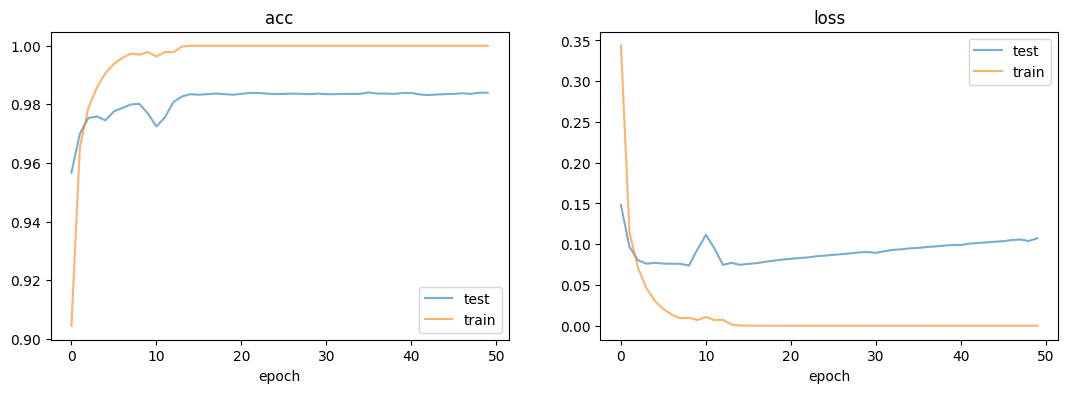

Model(
  (layer0): Linear(in_features=784, out_features=1024, bias=True)
  (layer1): Linear(in_features=1024, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer3): Linear(in_features=1024, out_features=10, bias=True)
)

In [2]:
# Try running, will take about a minute
# Will plot the train & test loss & accuracy w.r.t the number of epochs we're training for
train_model(debug=False)

**Question**: After the previous cell has finished running, can you explain what's going on? What's happening with the test loss & accuracy?

**Answer**: 

### Part 2

In addition to train and test loss and accuracy, one metric we'll also consider is "Average Calibration Error" (ACE). To measure ACE we'll consider confidence histograms as shown below:

![image.png](https://drive.google.com/uc?export=view&id=1Gza_Tye2AC3afgTgE-GnbRYpIZsc8kaw)

If our classifier were perfectly calibrated, the blue rectangles of outputs would perfectly match with the gray line, and the red gap would have an area of 0. Measuring ACE will require calculating the average area of the red gap. Specifically, we'll do:

- Group predictions into $M=15$ interval bins, each of size $1/M$, where bin $B_m$ has predictions whose confidence $\textrm{conf}(B_m)$ fall in the interval $I_m = (\frac{m-1}{M}, \frac{m}{M}]$.
- Define $\textrm{acc}(B_m) = \frac{1}{|B_m|} \sum_{i\in B_m} \textbf{1}(\hat{y_i} = y_i)$ where $\hat{y_i}$ is the predicted (argmax) label for sample $i$ and $y_i$ is the actual label.
- Define $\textrm{conf}(B_m) = \frac{1}{|B_m|} \sum_{i\in B_m} \hat{p_i}$ where $\hat{p_i}$ is the confidence (probability of the predicted class) for sample $i$.
- Then, $\textrm{ACE} = \frac{1}{M} \sum_{m=1}^{M} |\textrm{acc}(B_m) - \textrm{conf}(B_m)|$

Finish implementing the ACE calculation below and try re-running the model training code to see the metric for the train/test data splits.

You should see something that looks like the following plot:

![image.png](https://drive.google.com/uc?export=view&id=150zhabgh57UE9f8PwD1jemIBhd0pxp1J)

In [26]:
# TODO: IMPLEMENT ACE_CALC

def ace_calc(logprobs, accs, m_bins=15):
    # logprobs and confs: shape (n_batch,)
    # NOTE: logprobs is already the logprobs of the predicted class
    # not the full (n_batch, n_classes) array
    # accs: shape (n_batch,), 1 if prediction was correct, 0 if incorrect
    confs = np.exp(logprobs)

    gaps = []
    M = 0
    for s in range(0, 100, 15):
      lower = float(s) / 100.
      upper = float(min(s + 15, 100)) / 100.
      indx = (confs <= upper) * (confs > lower)
      M += 1
      if sum(indx) == 0:
        continue
      avg_conf = np.mean(confs[indx])
      avg_acc = np.mean(accs[indx])
      gaps.append(np.abs(avg_conf - avg_acc))
    return np.sum(gaps) / float(M)

    # Hint: Don't worry too much about optimizing your solution, first get something working

    # Return ACE = 1/M sum(m=1, M) |acc(B_m) - conf(B_m)|
    ace = None
    return ace

In [27]:
# TODO: ADD TEST CASES

probs = [1.0, 1.0, 0.95] # 0.96667
log_probs = np.log(probs)
accs = np.array([1, 1, 1]) # 1

print(ace_calc(log_probs, accs))


# Before you try training a model, try writing some test cases
# to assert your implementation of `ace_calc` is correct.
# In particular, think of testing a few hardcoded distributions for
# which you already know the expected ACE.
# raise NotImplementedError

0.0023809523809523725


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


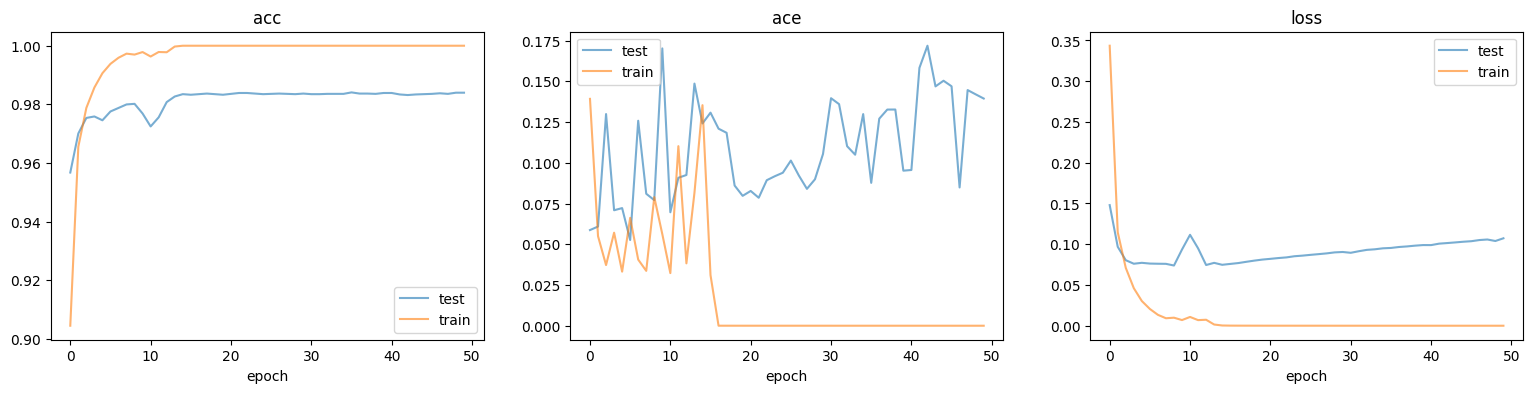

Model(
  (layer0): Linear(in_features=784, out_features=1024, bias=True)
  (layer1): Linear(in_features=1024, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer3): Linear(in_features=1024, out_features=10, bias=True)
)

In [28]:
# Try running
train_model(debug=False)

### Part 3

**Question**: What's your interpretation of the previous graphs? What's going on with the train/test loss, accuracy, and ACE? In particular: 1) why does ACE go to 0 for the training set?, 2) what's going on with the test ACE?, and 3) why is the ACE metric "spiky" / high variance between consecutive epochs (keep in mind we're compute ACE on the entire training & test sets)?

**Answer**: TODO

### Part 4

This part is more open-ended: can you try to come up with some improvements to the ACE metric? It may be useful to try printing how the bins change over the course of training, or plotting what the actual histogram looks like.

In [ ]:
raise NotImplementedError